In [1]:
import pandas as pd
import numpy as np
import os
import tensorflow as tf
import tensorflow.keras as k
import tensorflow_addons as tfa
import tensorflow.keras.layers as kl
from tensorflow.keras import optimizers 
from tensorflow.keras import regularizers 
from tensorflow.keras import losses 
from tensorflow.keras import metrics as kmetrics
from sklearn import metrics as skmetrics
import matplotlib.pyplot as plt

from IPython.display import clear_output

from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
import seaborn as sns

from IPython import display
from datetime import datetime as dt

from data.utils import WindowDataset

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
pd.set_option('display.max_colwidth', 100)
plt.rcParams["figure.figsize"] = (16, 8)

gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
   # Currently, memory growth needs to be the same across GPUs
   try:
       for gpu in gpus:
           tf.config.experimental.set_memory_growth(gpu, True)
   except RuntimeError as e:
       print(e)

def legend_without_duplicate_labels(ax):
    handles, labels = ax.get_legend_handles_labels()
    unique = [(h, l) for i, (h, l) in enumerate(zip(handles, labels)) if l not in labels[:i]]
    ax.legend(*zip(*unique), markerscale=4, fontsize=18)        

from matplotlib import cm
import matplotlib

    
%matplotlib inline

In [2]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

# Parameters

In [3]:
data_path = os.environ['ENGINE_FAULT_DETECTION_PROJECT_DATA_PATH']
models_path = os.environ['ENGINE_FAULT_DETECTION_PROJECT_MODELS_PATH']

class Bunch:
    __init__ = lambda self, **kw: setattr(self, '__dict__', kw)
args = Bunch()    

args.train_test_split_ratio = 0.7
args.batch_size = 8
args.epochs = 1000
args.windows_per_epoch = int(1e6)
args.active_channels = 17
args.initial_learning_rate = 1e-3
args.decay = args.initial_learning_rate / args.epochs
args.warmup_steps = 1

model_name = 'GCAEC_zema_pump_fault'
dataset_path = '../../data/condition_monitoring_of_hydraulic_systems_data_set_at_ZeMA/condition_monitoring_of_hydraulic_systems_data_set_at_ZeMA_pump_subclass.csv'

now = dt.now()
log_name = '{}_epochs_{}_{}_{}_{}.h5'.format(model_name, args.epochs, now.day, now.hour, now.minute)
hist_log_name = '{}_epochs_{}_{}_{}_{}.csv'.format(model_name, args.epochs, now.day, now.hour, now.minute)

In [4]:
color_nominal = matplotlib.colors.to_rgba('C2')
color_pga_leak = matplotlib.colors.to_rgba('C1')
color_fluid_leak = matplotlib.colors.to_rgba('C0')
color_cooler_fault = matplotlib.colors.to_rgba('C4')
color_valve_error = matplotlib.colors.to_rgba('C3')

class_names = [
    'Исправный насос',
    'Слабая утечка',
    'Cильная утечка'
]

class_colors = np.array([
    matplotlib.colors.hex2color('#2ca02c'),
    matplotlib.colors.hex2color('#6BB1E3'),
    matplotlib.colors.hex2color('#1f77b4')
])

In [5]:
def noam_based_decay(epoch, lr):
    epoch += 1    
    return args.initial_learning_rate * args.warmup_steps**0.5 * min(epoch**-0.5, epoch*(args.warmup_steps**-1.5)) 

# Dataset

In [6]:
dataset_description = pd.read_csv(dataset_path, skipinitialspace=True)
dataset_description

fp  cid             name
0     sensors_numpy/record_0000.npy    0  Исправный насос
1     sensors_numpy/record_0001.npy    0  Исправный насос
2     sensors_numpy/record_0002.npy    0  Исправный насос
3     sensors_numpy/record_0003.npy    0  Исправный насос
4     sensors_numpy/record_0004.npy    0  Исправный насос
...                             ...  ...              ...
2200  sensors_numpy/record_2109.npy    2   Cильная утечка
2201  sensors_numpy/record_2110.npy    2   Cильная утечка
2202  sensors_numpy/record_2111.npy    2   Cильная утечка
2203  sensors_numpy/record_2112.npy    2   Cильная утечка
2204  sensors_numpy/record_2113.npy    2   Cильная утечка

[2205 rows x 3 columns]

In [7]:
indexes = [np.arange(x) for x in dataset_description.cid.value_counts().sort_index()]
global_shifts = np.concatenate([np.array([0]), np.cumsum(dataset_description.cid.value_counts().sort_index())])

for x in indexes:
    np.random.shuffle(x)

train_indexes = np.concatenate([x[:int(len(x)*args.train_test_split_ratio)] + global_shifts[i] for i,x in enumerate(indexes)])
test_indexes = np.concatenate([x[int(len(x)*args.train_test_split_ratio):] + global_shifts[i] for i,x in enumerate(indexes)])

train_labels_true = np.concatenate([np.repeat(i, x[:int(len(x)*args.train_test_split_ratio)].shape[0]) for i,x in enumerate(indexes)])
test_labels_true = np.concatenate([np.repeat(i, x[int(len(x)*args.train_test_split_ratio):].shape[0]) for i,x in enumerate(indexes)])

train_index_of_indexes = np.arange(len(train_indexes))
np.random.shuffle(train_index_of_indexes)
train_indexes = train_indexes[train_index_of_indexes]
train_labels_true = train_labels_true[train_index_of_indexes]

train_indexes.shape, train_labels_true.shape, test_indexes.shape, test_labels_true.shape

((1542,), (1542,), (663,), (663,))

In [8]:
X_train_records = np.stack([np.load('../../data/condition_monitoring_of_hydraulic_systems_data_set_at_ZeMA/' + file) for file in dataset_description.iloc[train_indexes].fp])[:,:,1:]
X_test_records = np.stack([np.load('../../data/condition_monitoring_of_hydraulic_systems_data_set_at_ZeMA/' + file) for file in dataset_description.iloc[test_indexes].fp])[:,:,1:]

X_train_records = X_train_records.reshape(X_train_records.shape[0],X_train_records.shape[1],X_train_records.shape[2]//6,6).mean(axis=3)
X_test_records = X_test_records.reshape(X_test_records.shape[0],X_test_records.shape[1],X_test_records.shape[2]//6,6).mean(axis=3)

# channels_means = X_train_records.max(axis=2).max(axis=0)
# X_train_records = X_train_records/np.tile(channels_means, (X_train_records.shape[0],1000,1)).transpose([0,2,1])
# X_test_records = X_test_records/np.tile(channels_means, (X_test_records.shape[0],1000,1)).transpose([0,2,1])

X_train_records = X_train_records.transpose([0,2,1])
X_test_records = X_test_records.transpose([0,2,1])

In [9]:
X_train_records.shape, X_test_records.shape

((1542, 1000, 17), (663, 1000, 17))

In [10]:
def get_input(record, label):
    return (record, (record, label, label))

def get_types():
    return (tf.float32, (tf.float32, tf.int8, tf.int8))

def get_shape():
    return (tf.TensorShape(X_train_records.shape[1:]),  (tf.TensorShape(X_train_records.shape[1:]), tf.TensorShape([]), tf.TensorShape([])))

def gen():
    for record, label in zip(X_train_records, train_labels_true):
        yield get_input(record, label)

X_train = tf.data.Dataset.from_generator(
             gen, 
             get_types(),
             get_shape())
        
def gen():
    for record, label in zip(X_test_records, test_labels_true):
        yield get_input(record, label)
    
X_test = tf.data.Dataset.from_generator(
             gen, 
             get_types(),
             get_shape())

# Model

In [11]:
input_shape = X_train_records.shape[1:]
embedding_size = 2
units = 16
kernel_size = 3

conv_num = -1
def conv_block_name():
    global conv_num
    conv_num = conv_num + 1
    return 'cb_{}'.format(conv_num)

def conv_block(output_timesteps, output_channels, name, dilation=1):
    def f(preceding_layer):
        input_timesteps, input_channels = preceding_layer.get_shape().as_list()[1:]
        
        inputs = k.Input(shape=(input_timesteps, input_channels))
               
        act = kl.Conv1D(output_channels, kernel_size=kernel_size, activation='linear', padding='same', name=name+'_conv_features1', dilation_rate=dilation)(inputs)
        gate = kl.Conv1D(output_channels, kernel_size=kernel_size, activation='sigmoid', padding='same', name=name+'_conv_memory', dilation_rate=dilation)(inputs)
        gated_act = kl.Multiply()([tfa.layers.InstanceNormalization()(kl.PReLU()(act)), gate]) 
               
        a = kl.Permute((2,1))(gated_act)
        b = kl.Dense(output_timesteps)(a)
        c = kl.Permute((2,1))(b)
        
        m = k.Model(inputs=inputs, outputs=[c, gate], name=name)
#         m.summary()
        return m(preceding_layer)
    return f

inputs = k.Input(shape=input_shape)

e, g1 = conv_block(output_timesteps=100, output_channels=units, name=conv_block_name())(inputs)
e, g2 = conv_block(output_timesteps=50, output_channels=units, name=conv_block_name())(e)
e, g3 = conv_block(output_timesteps=25, output_channels=units, name=conv_block_name())(e)
e, g4 = conv_block(output_timesteps=10, output_channels=units, name=conv_block_name())(e)

d, g5 = conv_block(output_timesteps=25, output_channels=units, name=conv_block_name())(e)
d, g6 = conv_block(output_timesteps=50, output_channels=units, name=conv_block_name())(d)
d, g7 = conv_block(output_timesteps=100, output_channels=units, name=conv_block_name())(d)
d, g8 = conv_block(output_timesteps=X_train_records.shape[1], output_channels=X_train_records.shape[2], name='decoder_output')(d)

decoder_output = d

ef = kl.Flatten()(e)
embedding_output = kl.Dense(embedding_size, activation='linear', name='emb')(ef)
softmax_output = kl.Dense(5, activation='softmax', name='softmax_layer')(embedding_output)
label_output = kl.Lambda(lambda x: k.backend.argmax(x), name='label_layer')(softmax_output)

autoencoder_model = k.Model(inputs=inputs, outputs=[decoder_output, softmax_output, label_output], name='autoencoder')
encoder_model = k.Model(inputs=inputs, outputs=embedding_output, name='encoder')
classifier_model = k.Model(inputs=inputs, outputs=[softmax_output, label_output], name='classifier')

autoencoder_model.summary()

Model: "autoencoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 1000, 17)]   0                                            
__________________________________________________________________________________________________
cb_0 (Functional)               [(None, 100, 16), (N 117796      input_1[0][0]                    
__________________________________________________________________________________________________
cb_1 (Functional)               [(None, 50, 16), (No 8250        cb_0[0][0]                       
__________________________________________________________________________________________________
cb_2 (Functional)               [(None, 25, 16), (No 3675        cb_1[0][0]                       
________________________________________________________________________________________

# Train

In [12]:
class History:
    def __init__(self, path):
        self.path = path
        self.train_loss = []
        self.train_ae_loss = []
        self.train_classifier_loss = []
        self.train_classifier_acc = []
        
        self.test_loss = []
        self.test_ae_loss = []
        self.test_classifier_loss = []
        self.test_classifier_acc = []

        
    def save_state(self):
        df = pd.DataFrame({i:d[i] for i in self.__dict__ if i != 'path'})
        df.to_csv(self.path, index=False)
    
    def load_state(self):
        df = pd.read_csv(self.path)
        for c in df.columns:
            self.__dict__[c] = df[c].to_list()
        
history = History(hist_log_name)

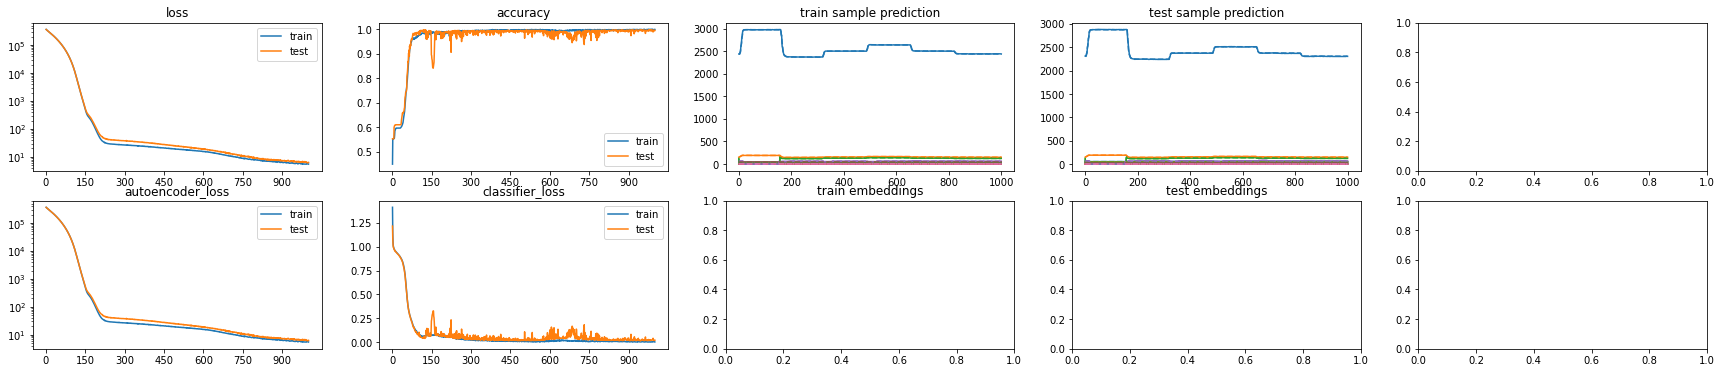

1:19:34.463707 1000/1000
train_loss: 5.4851823, test_loss:6.3205695
train_acc: 100.00, test_acc:99.55
train_ae_loss: 5.4807305, test_ae_loss:6.2978892
CPU times: user 1h 31min 29s, sys: 4min 16s, total: 1h 35min 45s
Wall time: 1h 19min 34s


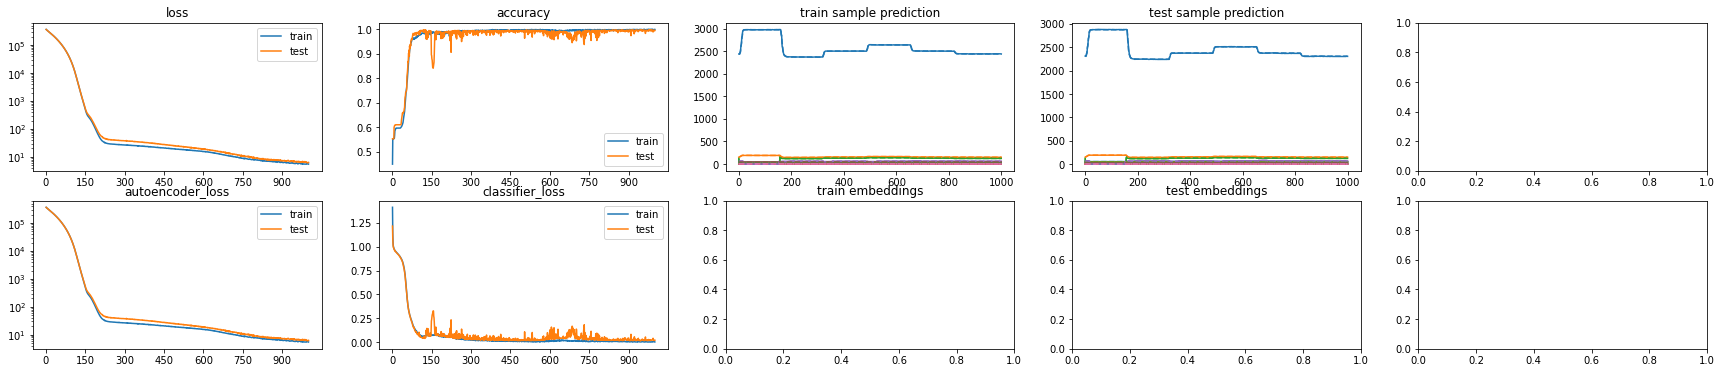

In [13]:
%%time 

start_time = dt.now()

fig, [[ax1, ax2, ax3, ax4, ax5], [ax10, ax20, ax30, ax40, ax50]] = plt.subplots(2,5, figsize=(30,6), gridspec_kw={'width_ratios':[0.2, 0.2, 0.2, 0.2, 0.2]})

# # samples = max(10000, int(X.number_of_windows*0.1))
samples = 10000

callbacks = []
class DrawingCallback(k.callbacks.Callback):
    def __init__(self, history):
        self.history = history
        self.train_sample = X_train.take(samples)
        self.test_sample = X_test.take(samples)
        self.train_sample_1 = list(X_train.take(1).as_numpy_iterator())[0][0]
        self.test_sample_1 = list(X_test.take(1).as_numpy_iterator())[0][0]
    
    def on_epoch_end(self, epoch, logs={}):
        train_results = logs
        train_loss, train_ae_loss, train_classifier_loss, train_classifier_acc = train_results['loss'], train_results['decoder_output_loss'], train_results['softmax_layer_loss'], train_results['softmax_layer_sparse_categorical_accuracy']
        
        test_results = autoencoder_model.evaluate(self.test_sample.batch(args.batch_size), return_dict=True)
        test_loss, test_ae_loss, test_classifier_loss, test_classifier_acc = test_results['loss'], test_results['decoder_output_loss'], test_results['softmax_layer_loss'], test_results['softmax_layer_sparse_categorical_accuracy']
        
        predicted_train, _, _ = autoencoder_model.predict(self.train_sample_1[np.newaxis])
        predicted_test, _, _ = autoencoder_model.predict(self.test_sample_1[np.newaxis])
        predicted_train_z = encoder_model.predict(self.train_sample.batch(args.batch_size))
        predicted_test_z = encoder_model.predict(self.test_sample.batch(args.batch_size))
        
        self.history.train_loss.append(train_loss)
        self.history.train_ae_loss.append(train_ae_loss)
        self.history.train_classifier_loss.append(train_classifier_loss)
        self.history.train_classifier_acc.append(train_classifier_acc)
        self.history.test_loss.append(test_loss)
        self.history.test_ae_loss.append(test_ae_loss)
        self.history.test_classifier_loss.append(test_classifier_loss)
        self.history.test_classifier_acc.append(test_classifier_acc)
               
        ax1.cla()
        ax2.cla()
        ax3.cla()
        ax4.cla()
        ax5.cla()
        ax10.cla()
        ax20.cla()
        ax30.cla()
        ax40.cla()
        ax50.cla()
        
        ax1.set_title("loss")
        ax10.set_title("autoencoder_loss")
        ax20.set_title("classifier_loss")
        ax2.set_title("accuracy")
        
        ax1.set_yscale('log')
        ax10.set_yscale('log')
        
        ax3.set_title("train sample prediction")
        ax4.set_title("test sample prediction")
        ax30.set_title("train embeddings")
        ax40.set_title("test embeddings")

        ax1.xaxis.set_major_locator(plt.MaxNLocator(integer=True))
        ax1.plot(range(1, len(self.history.train_loss)+1), self.history.train_loss, label='train')
        ax1.plot(range(1, len(self.history.test_loss)+1), self.history.test_loss, label='test')
        ax1.legend()        
    
        ax2.xaxis.set_major_locator(plt.MaxNLocator(integer=True))
        ax2.plot(range(1, len(self.history.train_classifier_acc)+1), self.history.train_classifier_acc, label='train')
        ax2.plot(range(1, len(self.history.test_classifier_acc)+1), self.history.test_classifier_acc, label='test')
        ax2.legend()
        
        ax10.xaxis.set_major_locator(plt.MaxNLocator(integer=True))
        ax10.plot(range(1, len(self.history.train_ae_loss)+1), self.history.train_ae_loss, label='train')
        ax10.plot(range(1, len(self.history.test_ae_loss)+1), self.history.test_ae_loss, label='test')
        ax10.legend()
        
        ax20.xaxis.set_major_locator(plt.MaxNLocator(integer=True))
        ax20.plot(range(1, len(self.history.train_classifier_loss)+1), self.history.train_classifier_loss, label='train')
        ax20.plot(range(1, len(self.history.test_classifier_loss)+1), self.history.test_classifier_loss, label='test')
        ax20.legend()
        
        Xtrain_sample = self.train_sample_1 
        ax3.plot(Xtrain_sample, label='true')
        ax3.set_prop_cycle(None)
        ax3.plot(predicted_train[0], label='predicted', linestyle='dashed')
#         ax3.legend()
        
        Xtest_sample = self.test_sample_1
        ax4.plot(Xtest_sample, label='true')
        ax4.set_prop_cycle(None)
        ax4.plot(predicted_test[0], label='predicted', linestyle='dashed')
#         ax4.legend()
        

#         def legend_without_duplicate_labels(ax):
#             handles, labels = ax.get_legend_handles_labels()
#             unique = [(h, l) for i, (h, l) in enumerate(zip(handles, labels)) if l not in labels[:i]]
#             ax.legend(*zip(*unique))

#         for i in range(X.number_of_source_files):
#             x = predicted_train_z[np.arange(samples)%X.number_of_source_files==i,0]
#             y = predicted_train_z[np.arange(samples)%X.number_of_source_files==i,1]
#             class_label = X.timeseries_class_labels[i]
#             class_name = X.class_names[class_label]
#             class_color = class_colors[class_label]
#             ax30.scatter(x, y, s=2, label=class_name, color=class_color)       
            
# #         ax30.legend()
        
# #         legend_without_duplicate_labels(ax30)
        
#         for i in range(X.number_of_source_files):
#             x = predicted_test_z[np.arange(samples)%X.number_of_source_files==i,0]
#             y = predicted_test_z[np.arange(samples)%X.number_of_source_files==i,1]
#             class_label = X.timeseries_class_labels[i]
#             class_name = X.class_names[class_label]
#             class_color = class_colors[class_label]
#             ax40.scatter(x, y, s=2, label=class_name, color=class_color)       

#         ax40.legend()
#         legend_without_duplicate_labels(ax40)

        display.clear_output(wait=True)
        display.display(fig)
        print("{} {}/{}".format(dt.now()-start_time, epoch+1, args.epochs))
        print("train_loss: {:.7f}, test_loss:{:.7f}".format(self.history.train_loss[-1], self.history.test_loss[-1]))
        print("train_acc: {:.2f}, test_acc:{:.2f}".format(self.history.train_classifier_acc[-1]*100, self.history.test_classifier_acc[-1]*100))
        print("train_ae_loss: {:.7f}, test_ae_loss:{:.7f}".format(self.history.train_ae_loss[-1], self.history.test_ae_loss[-1]))


callbacks.append(DrawingCallback(history))

tensorboard_logs_dir = os.environ['ENGINE_FAULT_DETECTION_PROJECT_LOGS_PATH'] + 'tensorboard/'

log_dir = tensorboard_logs_dir + log_name
callbacks.append(k.callbacks.TensorBoard(log_dir=log_dir + '', histogram_freq=1))

callbacks.append(k.callbacks.LearningRateScheduler(noam_based_decay, verbose=1))
opt = optimizers.Adam(learning_rate=args.initial_learning_rate, beta_1=0.9, beta_2=0.98, epsilon=1e-9)

autoencoder_model.compile(optimizer=opt, 
                          loss={'decoder_output':losses.MSE,
                                'softmax_layer':losses.SparseCategoricalCrossentropy()}, 
                          loss_weights={'decoder_output':1.0, 'softmax_layer':1.0, 'label_layer':0.0},
                          metrics={
                             'softmax_layer': kmetrics.SparseCategoricalAccuracy(),
                          }
                         )

autoencoder_model.fit(X_train.batch(args.batch_size), epochs=args.epochs, verbose=1, callbacks=callbacks)

In [ ]:
autoencoder_model.save(models_path + model_name + '_ae.h5')
encoder_model.save(models_path + model_name + '_e.h5')
classifier_model.save(models_path + model_name + '_c.h5')

# Test

In [14]:
%%time

test_probs_predicted, test_labels_predicted = classifier_model.predict(X_test.batch(args.batch_size))

CPU times: user 580 ms, sys: 32.7 ms, total: 613 ms
Wall time: 577 ms


In [16]:
report = classification_report(test_labels_true, test_labels_predicted, target_names=class_names, digits=3)
print(report)

                 precision    recall  f1-score   support

Исправный насос      1.000     0.997     0.999       367
  Слабая утечка      0.980     1.000     0.990       148
 Cильная утечка      1.000     0.986     0.993       148

       accuracy                          0.995       663
      macro avg      0.993     0.995     0.994       663
   weighted avg      0.996     0.995     0.995       663



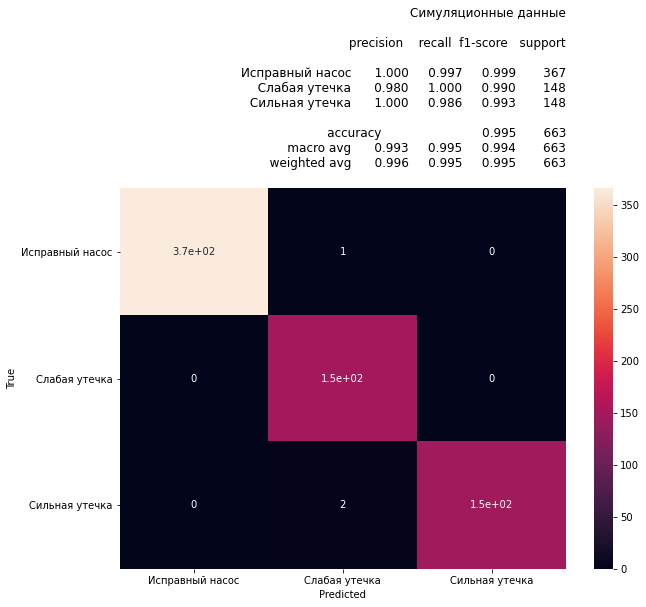

In [17]:
cf = confusion_matrix(test_labels_true, test_labels_predicted, normalize=None)

df_cm = pd.DataFrame(cf, index = class_names, columns = class_names)

plt.figure(figsize = (10,7))
sns.heatmap(df_cm, annot=True)
plt.ylabel('True')
plt.gca().set_yticklabels(plt.gca().get_yticklabels(), rotation=0)
plt.xlabel('Predicted')
plt.title("Симуляционные данные\n\n" + report, loc="right");

In [15]:
def custom_classifiaction_report(true, predicted):
    class_labels = sorted(set(true))
    report_rows = []
    for cid in class_labels:
        class_true = true.copy()
        class_true[true!=cid] = 0
        class_true[true==cid] = 1
        class_predicted = predicted.copy()
        class_predicted[predicted!=cid] = 0
        class_predicted[predicted==cid] = 1
        
        accuracy = skmetrics.accuracy_score(class_true, class_predicted)
        balanced_accuracy = skmetrics.balanced_accuracy_score(class_true, class_predicted)
        precision = skmetrics.precision_score(class_true, class_predicted, average='binary')
        recall = skmetrics.recall_score(class_true, class_predicted, average='binary')
        f1 = skmetrics.f1_score(class_true, class_predicted, average='binary')
        mcc = skmetrics.matthews_corrcoef(class_true, class_predicted)
        report_rows.append([accuracy*100, balanced_accuracy*100, precision, recall, f1, mcc])
    
    accuracy = skmetrics.accuracy_score(true, predicted)
    balanced_accuracy = skmetrics.balanced_accuracy_score(true, predicted)
    precision = skmetrics.precision_score(true, predicted, average='macro')
    recall = skmetrics.recall_score(true, predicted, average='macro')
    f1 = skmetrics.f1_score(true, predicted, average='macro')
    mcc = skmetrics.matthews_corrcoef(true, predicted)
    report_rows.append([accuracy*100, balanced_accuracy*100, precision, recall, f1, mcc])
    
    report = pd.DataFrame(
        report_rows, 
        columns=['accuracy', 'balanced_accuracy', 'precision', 'recall', 'f1', 'MCC'],
        index=class_names + ['Total'] )
    
    return report


In [18]:
metrics = custom_classifiaction_report(test_labels_true, test_labels_predicted)
metrics

accuracy  balanced_accuracy  precision    recall        f1       MCC
Исправный насос  99.849170          99.863760   1.000000  0.997275  0.998636  0.996954
Слабая утечка    99.547511          99.708738   0.980132  1.000000  0.989967  0.987129
Cильная утечка   99.698341          99.324324   1.000000  0.986486  0.993197  0.991297
Total            99.547511          99.458723   0.993377  0.994587  0.993933  0.992415